In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

df = pd.read_parquet("../data/processed/airquality_with_stl.parquet")
df.head()

,CO_GT,PT08_S1_CO,NMHC_GT,C6H6_GT,PT08_S2_NMHC,NOx_GT,PT08_S3_NOx,NO2_GT,PT08_S4_NO2,PT08_S5_O3,Temp,Humidity,Absolute_Humidity,CO_STL_Residual
Datetime,,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,-0.216784
2004-03-10 19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,-0.025548
2004-03-10 20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,-3.961025
2004-03-10 21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,-0.760440
2004-03-10 22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,0.058204


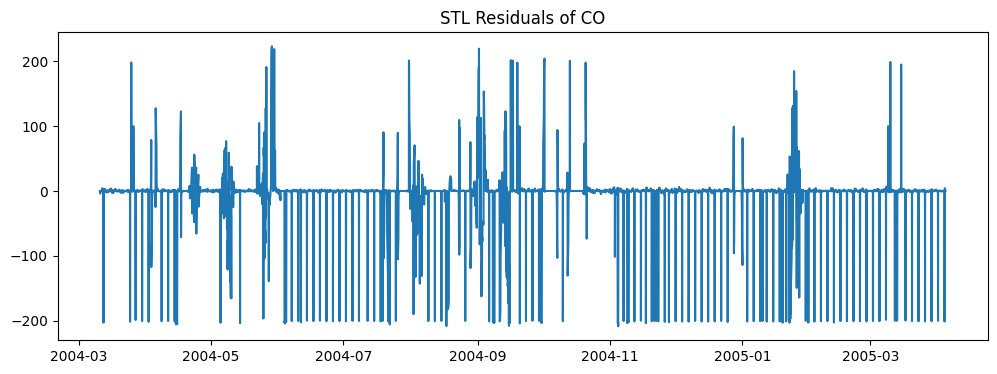

In [2]:
plt.figure(figsize=(12,4))
plt.plot(df.index, df['CO_STL_Residual'])
plt.title("STL Residuals of CO")
plt.show()

In [3]:
resid = df['CO_STL_Residual']

z_scores = (resid - resid.mean()) / resid.std()
df['Z_Anomaly'] = np.abs(z_scores) > 3

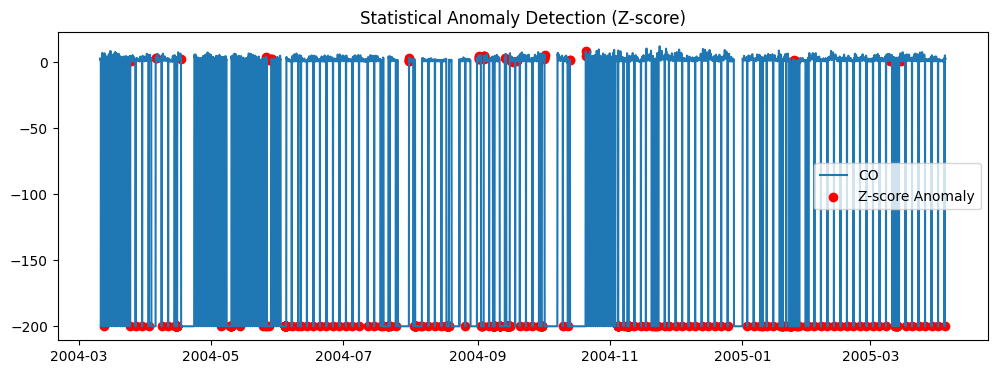

In [4]:
plt.figure(figsize=(12,4))
plt.plot(df.index, df['CO_GT'], label="CO")
plt.scatter(
    df.index[df['Z_Anomaly']],
    df['CO_GT'][df['Z_Anomaly']],
    color='red',
    label="Z-score Anomaly"
)
plt.legend()
plt.title("Statistical Anomaly Detection (Z-score)")
plt.show()

In [5]:
features = df[['CO_GT']].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

In [6]:
iso = IsolationForest(
    contamination=0.02,
    random_state=42
)

df.loc[features.index, 'IF_Anomaly'] = iso.fit_predict(X_scaled)
df['IF_Anomaly'] = df['IF_Anomaly'] == -1

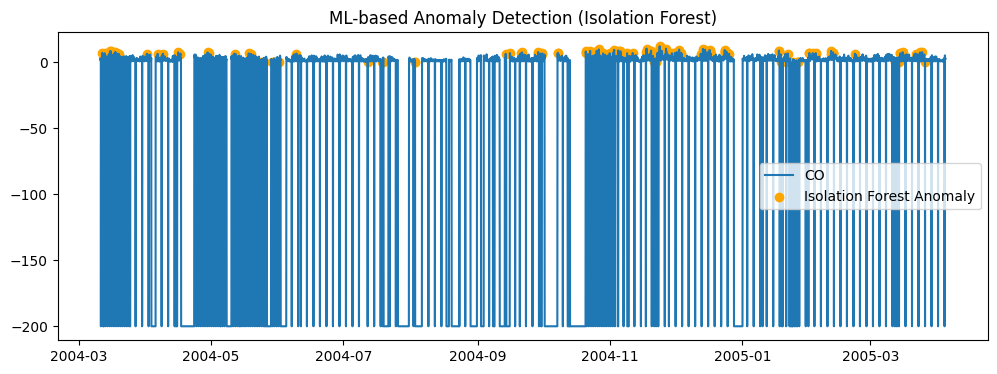

In [7]:
plt.figure(figsize=(12,4))
plt.plot(df.index, df['CO_GT'], label="CO")
plt.scatter(
    df.index[df['IF_Anomaly']],
    df['CO_GT'][df['IF_Anomaly']],
    color='orange',
    label="Isolation Forest Anomaly"
)
plt.legend()
plt.title("ML-based Anomaly Detection (Isolation Forest)")
plt.show()

In [8]:
df['Final_Anomaly'] = df['Z_Anomaly'] | df['IF_Anomaly']

In [9]:
df.to_parquet("../data/processed/airquality_with_anomalies.parquet")